In [11]:
import pandas as pd
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

df = pd.read_csv(r"C:\Users\annab\OneDrive\Documentos\GitHub\Colabs\bases\data_prema.csv")

# PROCESSAMENTO

In [12]:
df = df.drop(['RACACOR','CODOCUPMAE','ESCMAE', 'ESCMAE2010',
              'SERIESCMAE','SEMAGESTAC','IDADEPAI', 'DTNASCMAE',
              'STDNEPIDEM', 'STDNNOVA','TPAPRESENT', 'STTRABPART',
              'TPMETESTIM','IDANOMAL', 'CODANOMAL', 'CODESTAB', 
              'CODMUNNASC', 'LOCNASC', 'CODMUNRES', 'DTNASC', 
              'HORANASC','PARTO', 'PESO', 'APGAR1', 'APGAR5', 
              'DTCADASTRO', 'NUMEROLOTE', 'VERSAOSIST', 'DTRECEBIM', 
              'DIFDATA', 'DTRECORIGA', 'NATURALMAE', 'CODMUNNATU', 
              'CODUFNATU', 'DTULTMENST', 'CONSPRENAT', 'STCESPARTO', 
              'TPNASCASSI', 'TPFUNCRESP', 'TPDOCRESP', 'DTDECLARAC', 
              'CODPAISRES', 'TPROBSON', 'KOTELCHUCK', 'CONTADOR', 'ORIGEM'], axis=1)

In [13]:
df = df [(df['QTDFILVIVO'] < 12)]
df = df [(df['QTDFILMORT'] < 8)]
df = df[(df['IDADEMAE'] < 54)]

In [14]:
faixas_etarias = [0, 19, 24, 29, 34, 54]
rotulos_etarias = ['0-19', '20-24', '25-29', '30-34', '35-54']
df['FAIXA_ETARIA'] = pd.cut(df['IDADEMAE'], bins=faixas_etarias, labels=rotulos_etarias, right=False)
mapeamento_faixa_etaria = {'0-19': 0, '20-24': 1, '25-29': 2, '30-34': 3, '35-54': 4}
df['FAIXA_ETARIA_INT'] = df['FAIXA_ETARIA'].map(mapeamento_faixa_etaria)

df = df.drop(['FAIXA_ETARIA', 'IDADEMAE'], axis= 1)
df = df.dropna()

In [15]:
df_prema = df[df['GESTACAO'] <= 4].copy()
df_normal = df[df['GESTACAO'] > 4].copy()

df_prema['CLASSE'] = 1
df_normal['CLASSE'] = 0

In [16]:
df = df.drop(columns = ['GESTACAO'])

In [17]:
n_samples = len(df_prema)
df_normal_new = df_normal.sample(n=n_samples, random_state=42)

print("Tamanho de df_prema:", len(df_prema))
print("Tamanho de df_normal (após undersampling):", len(df_normal_new))

Tamanho de df_prema: 54706
Tamanho de df_normal (após undersampling): 54706


In [18]:
df_unificado = pd.concat([df_prema, df_normal_new], ignore_index=True)
df_unificado = df_unificado.drop(columns = ['GESTACAO'])

MODELOS


# DECISION TREE

Melhores parâmetros encontrados: {'criterion': 'gini', 'max_depth': 5, 'min_samples_leaf': 4, 'min_samples_split': 15}
              precision    recall  f1-score   support

           0       0.61      0.78      0.68     16247
           1       0.70      0.51      0.59     16577

    accuracy                           0.64     32824
   macro avg       0.65      0.64      0.64     32824
weighted avg       0.66      0.64      0.64     32824



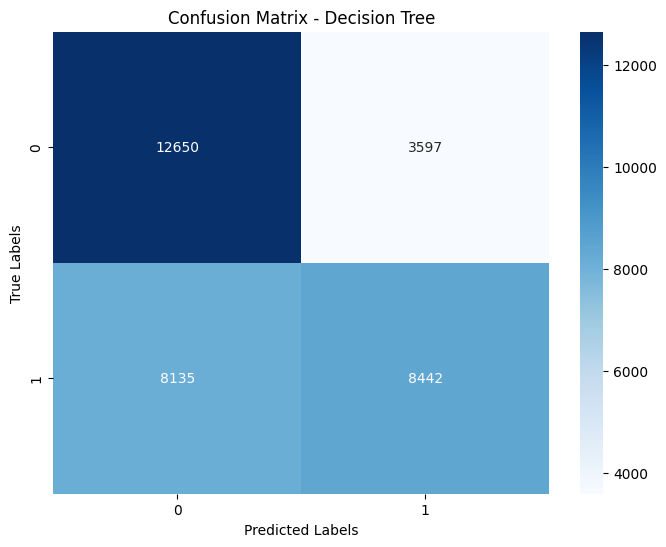

In [19]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.model_selection import GridSearchCV, train_test_split
import seaborn as sns
import matplotlib.pyplot as plt

X = df_unificado.drop('CLASSE', axis=1)
y = df_unificado['CLASSE']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

param_grid_dt = {
    'criterion': ['gini', 'entropy'],
    'max_depth': [None, 5, 10, 15],
    'min_samples_split': [2, 5, 10, 15],
    'min_samples_leaf': [1, 2, 4, 10]
}

dt_model = DecisionTreeClassifier(random_state=42)
grid_search_dt = GridSearchCV(estimator=dt_model, param_grid=param_grid_dt, cv=5, scoring='accuracy', n_jobs=-1)

grid_search_dt.fit(X_train, y_train)
best_params_dt = grid_search_dt.best_params_
print("Melhores parâmetros encontrados:", best_params_dt)

best_dt_model = DecisionTreeClassifier(random_state=42, **best_params_dt)
best_dt_model.fit(X_train, y_train)

y_pred_dt = best_dt_model.predict(X_test)
print(classification_report(y_test, y_pred_dt))

conf_matrix_dt = confusion_matrix(y_test, y_pred_dt)

plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix_dt, annot=True, fmt='d', cmap="Blues",
            xticklabels=best_dt_model.classes_,
            yticklabels=best_dt_model.classes_,
            cbar=True)
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title('Confusion Matrix - Decision Tree')
plt.show()

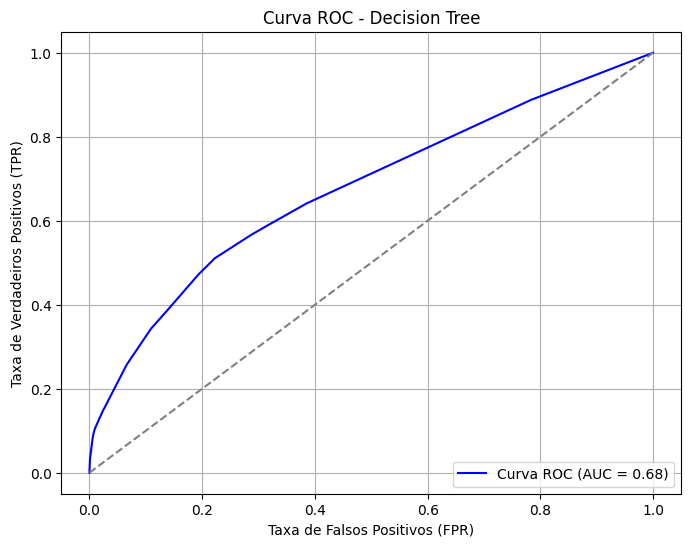

Melhor Threshold (baseado na Curva ROC): 0.4864864864864865
AUC: 0.675391352754238


In [20]:
# ACURACIA

from sklearn.metrics import roc_curve, auc
import numpy as np

y_pred_proba_dt = best_dt_model.predict_proba(X_test)[:, 1]
fpr, tpr, roc_thresholds = roc_curve(y_test, y_pred_proba_dt)
roc_auc = auc(fpr, tpr)

plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='blue', label='Curva ROC (AUC = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='gray', linestyle='--')
plt.xlabel('Taxa de Falsos Positivos (FPR)')
plt.ylabel('Taxa de Verdadeiros Positivos (TPR)')
plt.title('Curva ROC - Decision Tree')
plt.legend(loc='lower right')
plt.grid()
plt.show()

optimal_idx = np.argmax(tpr - fpr)
optimal_threshold = roc_thresholds[optimal_idx]

print("Melhor Threshold (baseado na Curva ROC):", optimal_threshold)
print("AUC:", roc_auc)

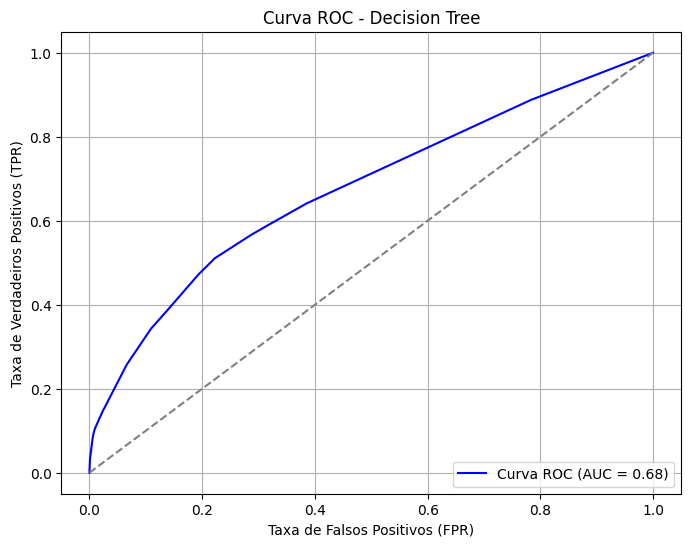

Melhor Threshold (baseado no Recall): 0.3392609699769053
AUC: 0.675391352754238


In [21]:
# SENSIBILIDADE

from sklearn.metrics import roc_curve, auc
import numpy as np
import matplotlib.pyplot as plt

y_pred_proba_dt = best_dt_model.predict_proba(X_test)[:, 1]

fpr, tpr, roc_thresholds = roc_curve(y_test, y_pred_proba_dt)
roc_auc = auc(fpr, tpr)

plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='blue', label='Curva ROC (AUC = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='gray', linestyle='--')
plt.xlabel('Taxa de Falsos Positivos (FPR)')
plt.ylabel('Taxa de Verdadeiros Positivos (TPR)')
plt.title('Curva ROC - Decision Tree')
plt.legend(loc='lower right')
plt.grid()
plt.show()

optimal_idx_recall = np.argmax(tpr)
optimal_threshold_recall = roc_thresholds[optimal_idx_recall]

print("Melhor Threshold (baseado no Recall):", optimal_threshold_recall)
print("AUC:", roc_auc)

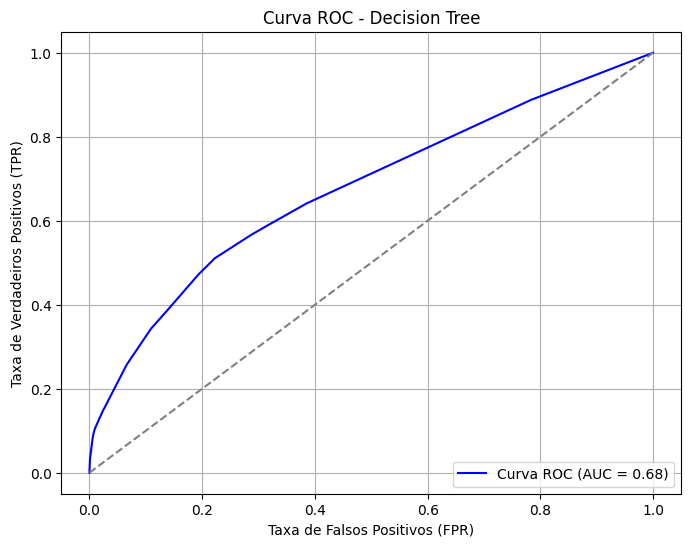

Melhor Threshold (baseado no F1-score): 0.3392609699769053
AUC: 0.675391352754238
F1-Score máximo: 0.6711200178134046


In [22]:
# F1-SCORE

from sklearn.metrics import roc_curve, auc, f1_score
import numpy as np
import matplotlib.pyplot as plt

y_pred_proba_dt = best_dt_model.predict_proba(X_test)[:, 1]

fpr, tpr, roc_thresholds = roc_curve(y_test, y_pred_proba_dt)
roc_auc = auc(fpr, tpr)

plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='blue', label='Curva ROC (AUC = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='gray', linestyle='--')
plt.xlabel('Taxa de Falsos Positivos (FPR)')
plt.ylabel('Taxa de Verdadeiros Positivos (TPR)')
plt.title('Curva ROC - Decision Tree')
plt.legend(loc='lower right')
plt.grid()
plt.show()

f1_scores = []
for threshold in roc_thresholds:
    y_pred_threshold = (y_pred_proba_dt >= threshold).astype(int)
    f1 = f1_score(y_test, y_pred_threshold)
    f1_scores.append(f1)

optimal_idx_f1 = np.argmax(f1_scores)
optimal_threshold_f1 = roc_thresholds[optimal_idx_f1]

print("Melhor Threshold (baseado no F1-score):", optimal_threshold_f1)
print("AUC:", roc_auc)
print("F1-Score máximo:", f1_scores[optimal_idx_f1])

In [23]:
# THRESHOLDS
print('ACURACIA',optimal_threshold)
print('SENSIBILIDADE',optimal_threshold_recall)
print('F1-SCORE',optimal_threshold_f1)

ACURACIA 0.4864864864864865
SENSIBILIDADE 0.3392609699769053
F1-SCORE 0.3392609699769053


c:\Users\annab\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\annab\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\annab\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, mo

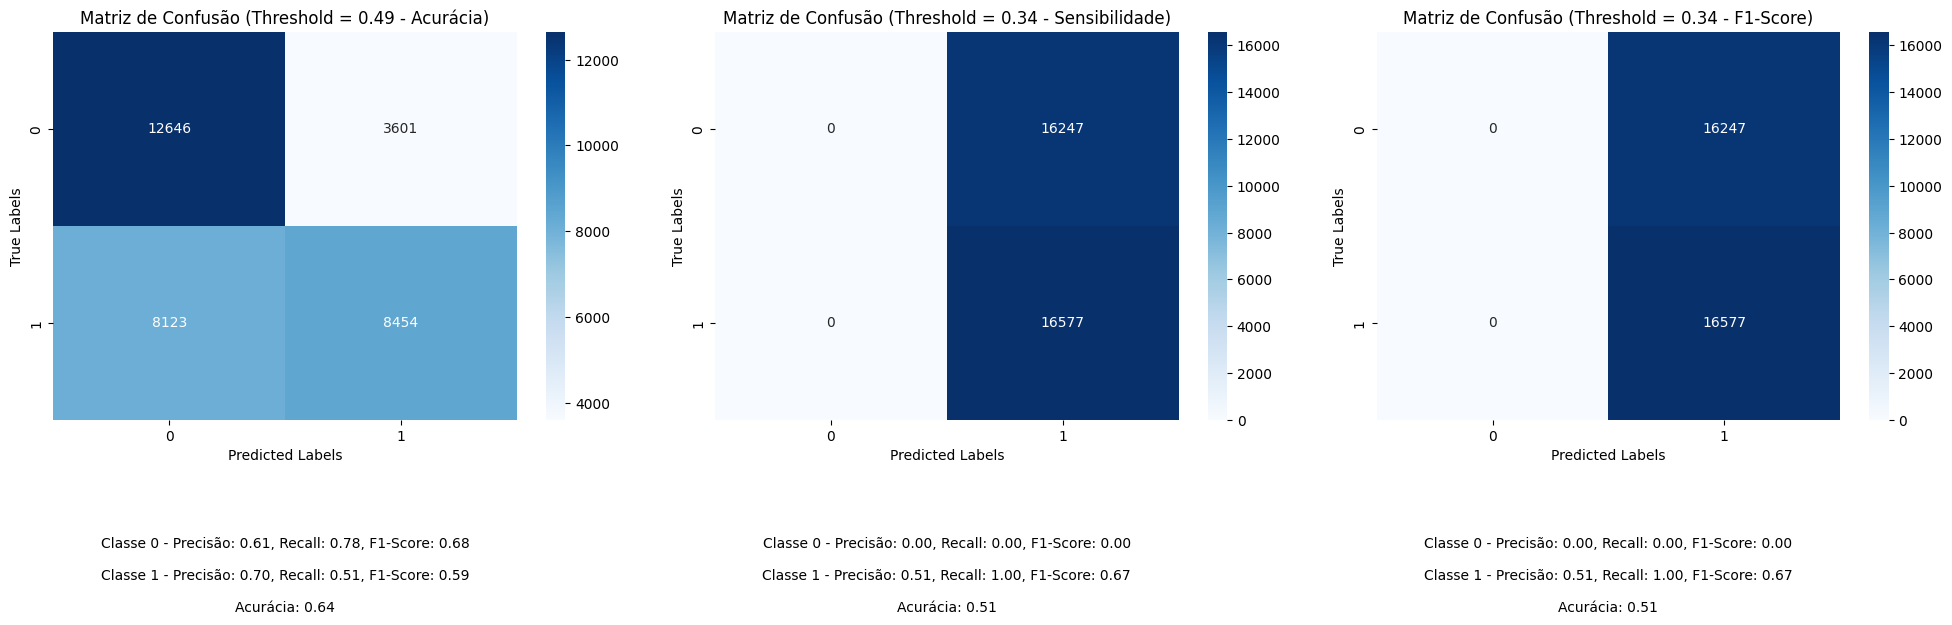

In [24]:
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
import seaborn as sns
import matplotlib.pyplot as plt

y_pred_proba_dt = best_dt_model.predict_proba(X_test)[:, 1]

threshold_accuracy = optimal_threshold
threshold_recall = optimal_threshold_recall
threshold_f1 = optimal_threshold_f1

thresholds = [("Acurácia", threshold_accuracy),
              ("Sensibilidade", threshold_recall),
              ("F1-Score", threshold_f1)]

fig, axes = plt.subplots(1, 3, figsize=(20, 10))

for i, (name, threshold) in enumerate(thresholds):
    y_pred_threshold_rf = (y_pred_proba_dt >= threshold).astype(int)

    conf_matrix_threshold_rf = confusion_matrix(y_test, y_pred_threshold_rf)

    sns.heatmap(conf_matrix_threshold_rf, annot=True, fmt='d', cmap="Blues",
                xticklabels=best_dt_model.classes_,
                yticklabels=best_dt_model.classes_,
                cbar=True, ax=axes[i])
    axes[i].set_xlabel('Predicted Labels')
    axes[i].set_ylabel('True Labels')
    axes[i].set_title(f'Matriz de Confusão (Threshold = {threshold:.2f} - {name})')

    class_report_dict = classification_report(y_test, y_pred_threshold_rf, output_dict=True)

    class_report_text = (
        f"Classe 0 - Precisão: {class_report_dict['0']['precision']:.2f}, "
        f"Recall: {class_report_dict['0']['recall']:.2f}, "
        f"F1-Score: {class_report_dict['0']['f1-score']:.2f}\n\n"
        f"Classe 1 - Precisão: {class_report_dict['1']['precision']:.2f}, "
        f"Recall: {class_report_dict['1']['recall']:.2f}, "
        f"F1-Score: {class_report_dict['1']['f1-score']:.2f}\n\n"
        f"Acurácia: {class_report_dict['accuracy']:.2f}"
    )

    axes[i].text(0.5, -0.3, class_report_text, ha="center", va="top",
                 fontsize=10, transform=axes[i].transAxes)

plt.tight_layout(rect=[0, 0.25, 1, 1])
plt.show()

# RANDOM FOREST

Melhores parâmetros encontrados: {'max_depth': 10, 'min_samples_leaf': 1, 'min_samples_split': 5, 'n_estimators': 100}
              precision    recall  f1-score   support

           0       0.61      0.75      0.67     16247
           1       0.68      0.54      0.60     16577

    accuracy                           0.64     32824
   macro avg       0.65      0.64      0.64     32824
weighted avg       0.65      0.64      0.64     32824



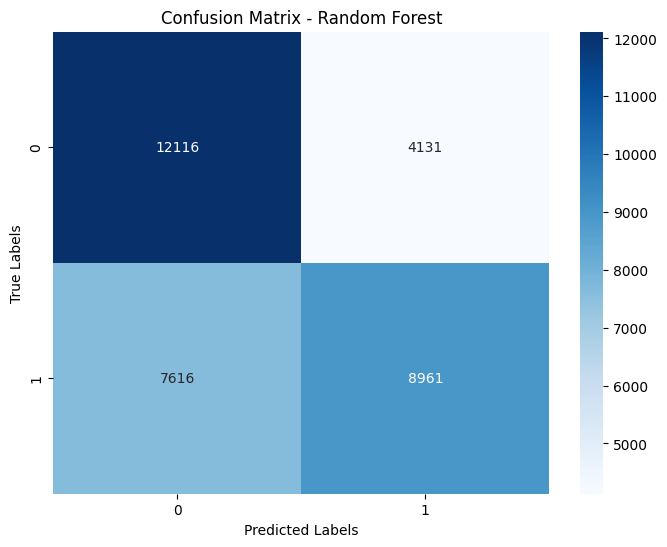

In [25]:
from sklearn.ensemble import RandomForestClassifier

X = df_unificado.drop('CLASSE', axis=1)
y = df_unificado['CLASSE']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

param_grid_rf = {
    'n_estimators': [25, 50, 100],
    'max_depth': [None, 10, 20],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4]
}

rf_model = RandomForestClassifier(random_state=42)

grid_search_rf = GridSearchCV(estimator=rf_model, param_grid=param_grid_rf, cv=5, scoring='accuracy', n_jobs=-1)

grid_search_rf.fit(X_train, y_train)
best_params_rf = grid_search_rf.best_params_
print("Melhores parâmetros encontrados:", best_params_rf)

best_rf_model = RandomForestClassifier(random_state=42, **best_params_rf)
best_rf_model.fit(X_train, y_train)

y_pred_rf = best_rf_model.predict(X_test)
print(classification_report(y_test, y_pred_rf))

conf_matrix_rf = confusion_matrix(y_test, y_pred_rf)

plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix_rf, annot=True, fmt='d', cmap="Blues",
            xticklabels=best_rf_model.classes_,
            yticklabels=best_rf_model.classes_,
            cbar=True)
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title('Confusion Matrix - Random Forest')
plt.show()

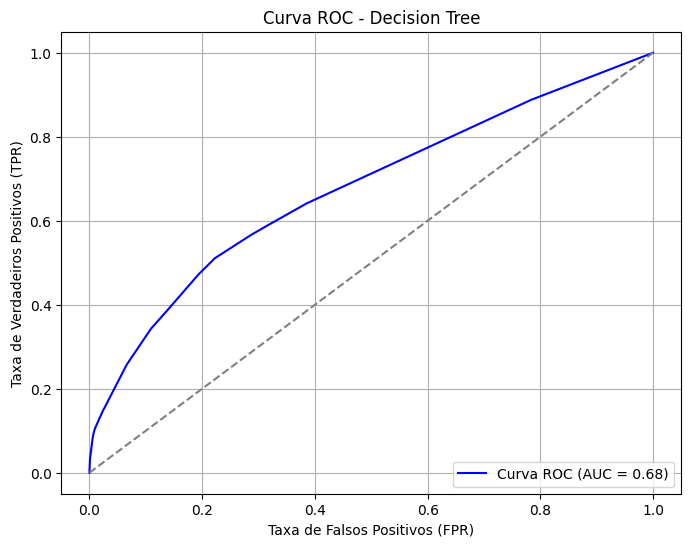

Melhor Threshold (baseado na Curva ROC): 0.4864864864864865
AUC: 0.675391352754238


In [26]:
## ACURACIA

from sklearn.metrics import roc_curve, auc
import numpy as np

y_pred_proba_dt = best_dt_model.predict_proba(X_test)[:, 1]
fpr, tpr, roc_thresholds = roc_curve(y_test, y_pred_proba_dt)
roc_auc = auc(fpr, tpr)

plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='blue', label='Curva ROC (AUC = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='gray', linestyle='--')
plt.xlabel('Taxa de Falsos Positivos (FPR)')
plt.ylabel('Taxa de Verdadeiros Positivos (TPR)')
plt.title('Curva ROC - Decision Tree')
plt.legend(loc='lower right')
plt.grid()
plt.show()

optimal_idx = np.argmax(tpr - fpr)
optimal_threshold = roc_thresholds[optimal_idx]

print("Melhor Threshold (baseado na Curva ROC):", optimal_threshold)
print("AUC:", roc_auc)


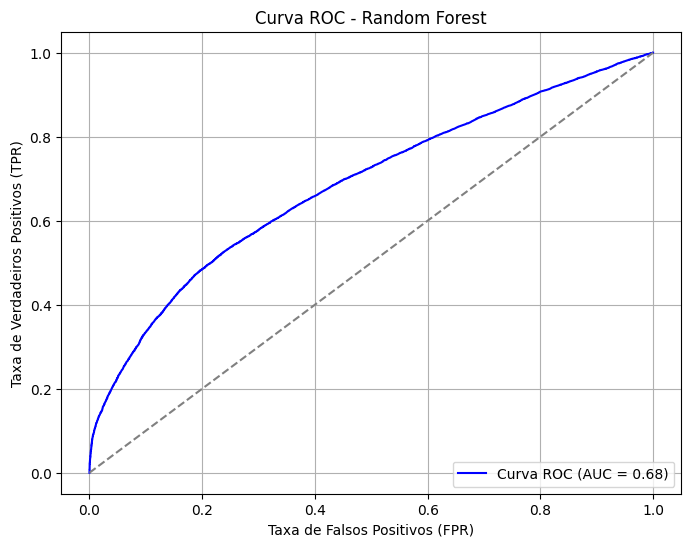

Melhor Threshold (baseado no Recall): 0.31411786990342067
AUC: 0.6848802475332925


In [27]:
# SENSIBILIDADE

from sklearn.metrics import roc_curve, auc
import numpy as np
import matplotlib.pyplot as plt

y_pred_proba_rf = best_rf_model.predict_proba(X_test)[:, 1]
fpr, tpr, roc_thresholds = roc_curve(y_test, y_pred_proba_rf)
roc_auc = auc(fpr, tpr)

plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='blue', label='Curva ROC (AUC = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='gray', linestyle='--')
plt.xlabel('Taxa de Falsos Positivos (FPR)')
plt.ylabel('Taxa de Verdadeiros Positivos (TPR)')
plt.title('Curva ROC - Random Forest')
plt.legend(loc='lower right')
plt.grid()
plt.show()

optimal_idx_recall = np.argmax(tpr)
optimal_threshold_recall = roc_thresholds[optimal_idx_recall]

print("Melhor Threshold (baseado no Recall):", optimal_threshold_recall)
print("AUC:", roc_auc)

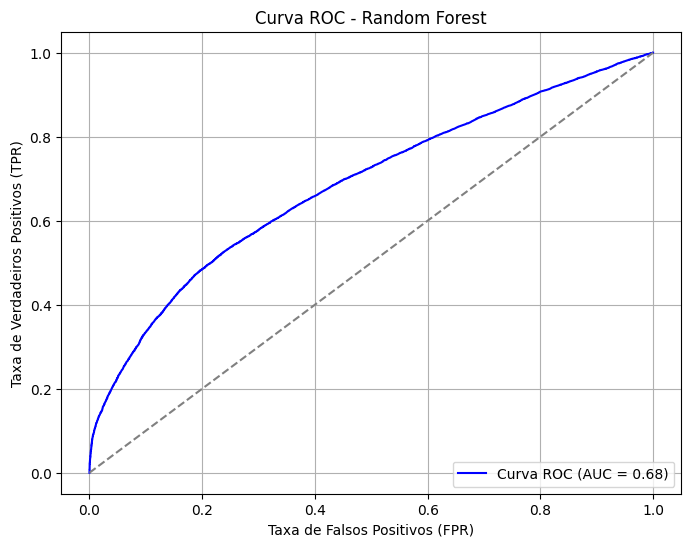

Melhor Threshold (baseado no F1-score): 0.3671200350964668
AUC: 0.6848802475332925


In [28]:
## F1-SCORE

from sklearn.metrics import roc_curve, auc, f1_score
import numpy as np
import matplotlib.pyplot as plt

y_pred_proba_rf = best_rf_model.predict_proba(X_test)[:, 1]

fpr, tpr, roc_thresholds = roc_curve(y_test, y_pred_proba_rf)
roc_auc = auc(fpr, tpr)

plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='blue', label='Curva ROC (AUC = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='gray', linestyle='--')
plt.xlabel('Taxa de Falsos Positivos (FPR)')
plt.ylabel('Taxa de Verdadeiros Positivos (TPR)')
plt.title('Curva ROC - Random Forest')
plt.legend(loc='lower right')
plt.grid()
plt.show()

f1_scores = []
for threshold in roc_thresholds:
    y_pred_threshold = (y_pred_proba_rf >= threshold).astype(int)
    f1 = f1_score(y_test, y_pred_threshold)
    f1_scores.append(f1)

optimal_idx_f1 = np.argmax(f1_scores)
optimal_threshold_f1 = roc_thresholds[optimal_idx_f1]

print("Melhor Threshold (baseado no F1-score):", optimal_threshold_f1)
print("AUC:", roc_auc)

In [29]:
# THRESHOLDS
print('ACURACIA',optimal_threshold)
print('SENSIBILIDADE',optimal_threshold_recall)
print('F1-SCORE',optimal_threshold_f1)

ACURACIA 0.4864864864864865
SENSIBILIDADE 0.31411786990342067
F1-SCORE 0.3671200350964668


c:\Users\annab\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\annab\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\annab\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, mo

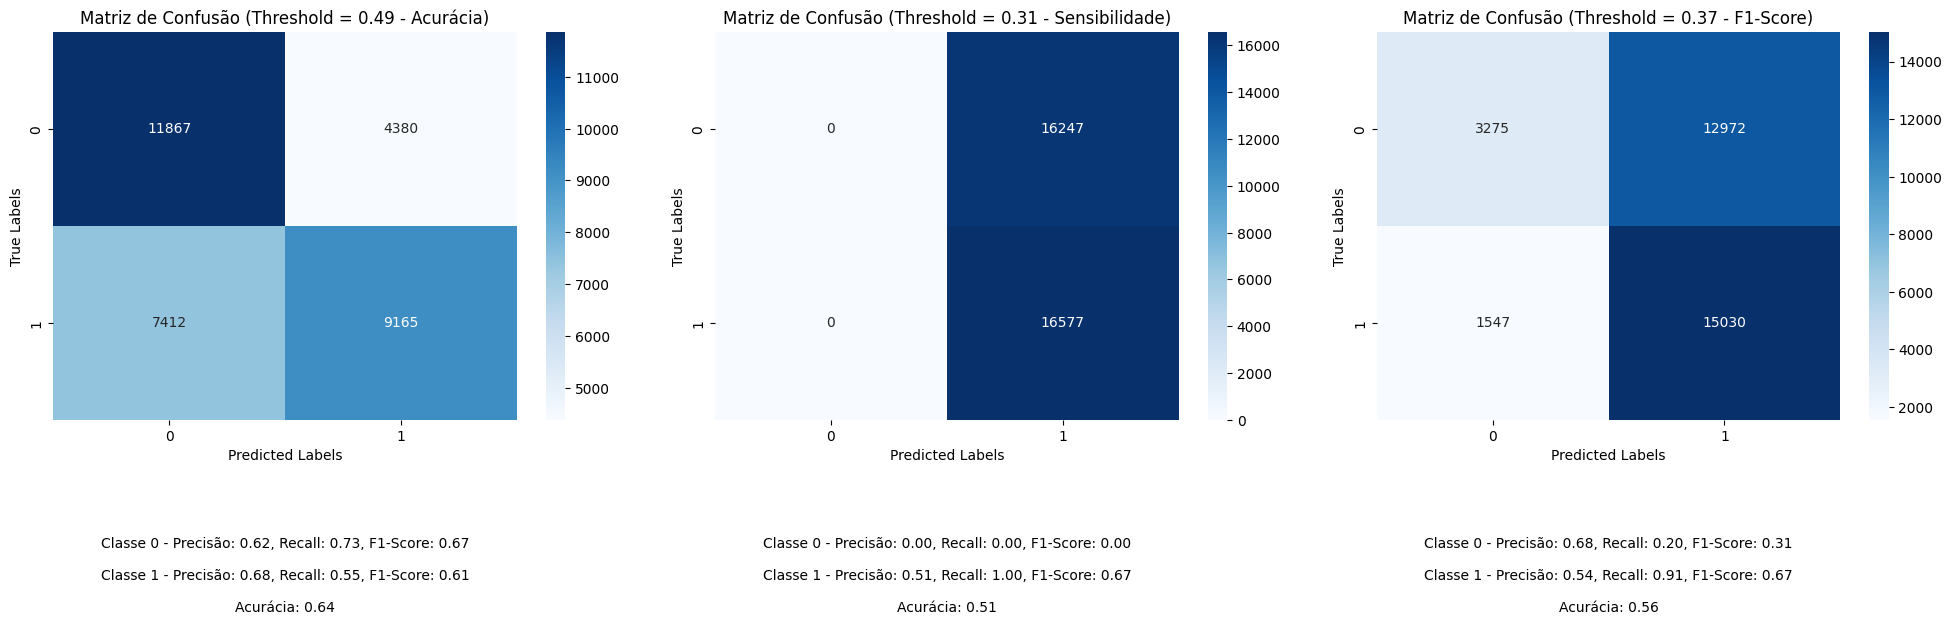

In [30]:
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
import seaborn as sns
import matplotlib.pyplot as plt

y_pred_proba_rf = best_rf_model.predict_proba(X_test)[:, 1]

threshold_accuracy = optimal_threshold
threshold_recall = optimal_threshold_recall
threshold_f1 = optimal_threshold_f1

thresholds = [("Acurácia", threshold_accuracy),
              ("Sensibilidade", threshold_recall),
              ("F1-Score", threshold_f1)]

fig, axes = plt.subplots(1, 3, figsize=(20, 10))

for i, (name, threshold) in enumerate(thresholds):
    y_pred_threshold_rf = (y_pred_proba_rf >= threshold).astype(int)

    conf_matrix_threshold_rf = confusion_matrix(y_test, y_pred_threshold_rf)

    sns.heatmap(conf_matrix_threshold_rf, annot=True, fmt='d', cmap="Blues",
                xticklabels=best_rf_model.classes_,
                yticklabels=best_rf_model.classes_,
                cbar=True, ax=axes[i])
    axes[i].set_xlabel('Predicted Labels')
    axes[i].set_ylabel('True Labels')
    axes[i].set_title(f'Matriz de Confusão (Threshold = {threshold:.2f} - {name})')

    class_report_dict = classification_report(y_test, y_pred_threshold_rf, output_dict=True)

    class_report_text = (
        f"Classe 0 - Precisão: {class_report_dict['0']['precision']:.2f}, "
        f"Recall: {class_report_dict['0']['recall']:.2f}, "
        f"F1-Score: {class_report_dict['0']['f1-score']:.2f}\n\n"
        f"Classe 1 - Precisão: {class_report_dict['1']['precision']:.2f}, "
        f"Recall: {class_report_dict['1']['recall']:.2f}, "
        f"F1-Score: {class_report_dict['1']['f1-score']:.2f}\n\n"
        f"Acurácia: {class_report_dict['accuracy']:.2f}"
    )

    axes[i].text(0.5, -0.3, class_report_text, ha="center", va="top",
                 fontsize=10, transform=axes[i].transAxes)

plt.tight_layout(rect=[0, 0.25, 1, 1])
plt.show()